## **Notebook 11: Playing with Dimensionality Reduction Algorithms**
### CBE 512. Machine Learning in Chemical Science and Engineering.

&#169; Princeton University

# **Dimensionality Reduction on Molecular Dynamics Data**

In computational chemistry, one is often faced with a challenge of distilling physical principles from high-dimensional data via analysis. One source of high-dimensional data comes from molecular dynamics simulation, which effectively provide access to coordinates, velocitis, and forces for all particles comprising a system, as a function of time.

Most simulations feature 10,000's of particles, which results in state vector that is ~90,000-dimensional. Consider that data may be stored every 1 ps (or so). This means that it in just 1 nanosecond of simulation, one may accrue 90,000,000 pieces of data. However, these pieces of data in isolation are hardly relevant. Techniques of *dimensionality reduction* can provide a pathway towards finding important correlations or patterns in this large swath of data.

### **Alanine Dipeptide as a case study**

The conformational states and associated free-energy landscape of alanine dipeptide is a canonical system of study in molecular simulation. It provides a simple system that possesses, for example, essential characteristics that would be of interest for building models/methods appropriate to larger biomolecules.

It is quite common to present the free-energy landscape on a ["Ramachandran" plot](https://en.wikipedia.org/wiki/Ramachandran_plot) where the two collective variables for representing the free-energy correspond to internal, neighboring dihedral angles.

A dihedral angle can be calculated from the Cartesian coordinates of four centers (it basically corresponds to the angle between two planes where each plane is defined by three points). The notion of a dihedral angle was something that we, as humans, invented as a suitable dimensionality reduction (12 --> 1).

Can unsupervised learning do something similar?

### **Description of the problem**

Prof. Webb has run a short molecuar dynamics simulation of alanine dipeptide in vacuum. The simulations were performed using [LAMMPS](https://lammps.org/#gsc.tab=0https://). System coordinates were recorded every 10ps. The resulting coordinate file was processed into .xyz format and provided as `ADPtrj.xyz`. The conventional dihedral angles were computed and stored in `dih.dump`. There should be 500 configurations/snapshots. Both files are hosted on the course GitHub as shown below.

In [12]:
# modules used by Prof. Webb
import os, sys, math, urllib.request
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import Isomap,TSNE

## **Data processing**

First, we will collect the data and organize it into a format amenable for processing by `scikit-learn` stuff.

In [13]:
# This array will hold 500 timeslices (frames) with 22 atoms, each having 3 coordinates (x, y, z)
# The array shape is (500, 22, 3), where:
# - 500 represents the number of time slices (frames) in the trajectory
# - 22 represents the number of atoms in the system
# - 3 represents the x, y, and z coordinates of each atom
txyz = np.zeros((500, 22, 3), dtype=float)

# URL to the raw .xyz file containing the trajectory data for alanine dipeptide
url_for_xyz = "https://raw.githubusercontent.com/webbtheosim/CBE512-MLinChmSciEng/main/data/ADP/ADPtrj.xyz"

# Initialize variables for time slice count (tcount) and atom count (acount)
tcount = -1  # tcount tracks the number of timeslices (starting at -1)
acount = 0   # acount tracks the number of atoms (starting at 0)

# Open the trajectory file from the URL and read it line by line
with urllib.request.urlopen(url_for_xyz) as f:
    for i, line in enumerate(f):
        templine = line.split()  # Split the line into components (atom information)

        if len(templine) == 1:  # This line indicates the start of a new timeslice
            tcount += 1    # Increment the timeslice counter
            acount = 0     # Reset atom counter for the new timeslice

        elif len(templine) == 4:  # This line contains coordinates for an atom
            # Parse the x, y, z coordinates of the atom from the line and store in the txyz array
            txyz[tcount, acount, 0] = float(templine[1])  # x-coordinate
            txyz[tcount, acount, 1] = float(templine[2])  # y-coordinate
            txyz[tcount, acount, 2] = float(templine[3])  # z-coordinate
            acount += 1  # Move to the next atom in the current timeslice

        else:
            continue  # Skip lines that do not contain coordinate data



In [14]:
# Initialize an array to store the two important dihedral collective variables (CVs) for each of the 500 timeslices.
# The array shape is (500, 2), where:
# - 500 represents the number of time slices (frames) in the trajectory
# - 2 represents the two dihedral CVs (cosine of the dihedral angles for each frame)
tdihedral = np.zeros((500, 2), dtype=float)

# Initialize a variable to track the timeslice count (tcount), starting at -1
tcount = -1

# Open the dihedral data file from the specified URL and read it line by line
with urllib.request.urlopen('https://raw.githubusercontent.com/webbtheosim/CBE512-MLinChmSciEng/main/data/ADP/dih.dump') as f:
    for i, line in enumerate(f):
        templine = line.split()  # Split the line into components

        # If the line contains the keyword 'TIMESTEP', it marks the beginning of a new timeslice
        if b'TIMESTEP' in line:
            tcount += 1  # Increment the timeslice counter

        # If the line contains the dihedral angle information for the first CV (corresponding to atoms 5, 7, 9, 15)
        if b'5 7 9 15' in line:
            # Extract the dihedral angle value, convert it to radians, and store the cosine of the angle in the first column of tdihedral
            tdihedral[tcount, 0] = np.cos(float(templine[-1]) * (math.pi / 180))  # Convert from degrees to radians

        # If the line contains the dihedral angle information for the second CV (corresponding to atoms 7, 9, 15, 17)
        if b'7 9 15 17' in line:
            # Extract the dihedral angle value, convert it to radians, and store the cosine of the angle in the second column of tdihedral
            tdihedral[tcount, 1] = np.cos(float(templine[-1]) * (math.pi / 180))  # Convert from degrees to radians


# **Preprocessing of Raw Data**

While it is possible to directly work with the Cartesian coordinates of the atoms, doing so might not effectively capture the underlying conformational states of the system. Cartesian coordinates alone can be too detailed and high-dimensional, making it difficult to isolate meaningful structural patterns.

To address this, we will transform the raw coordinates into a more informative feature representation by computing a **distance matrix**, which will possess certain invariances/equivariances that should make the analysis more robust. This matrix will capture the pairwise distances between atoms in each timeslice, effectively summarizing the spatial relationships between atoms. These pairwise distances serve as a more compact and relevant input representation for further analysis and modeling, particularly when we aim to identify and analyze distinct **conformational states** of the system.


In [15]:
# Compute distance matrix between all atoms in each timeslice
# This will compute the pairwise Euclidean distances between all pairs of atoms
# for each timeslice of the molecular dynamics trajectory

# Initialize an array to hold the flattened distance feature vectors for each timeslice.
# The array shape is (500, 231), where:
# - 500 corresponds to the number of timeslices (frames)
# - 231 corresponds to the number of unique pairs of atoms (since for 22 atoms, there are 231 unique pairs in the upper triangle of the distance matrix)
tdflat = np.zeros((500, 231), dtype=float)

# Get the indices of the upper triangle (excluding the diagonal) of the distance matrix.
# This gives the positions of the unique atom pairs for a 22-atom system (22 * (22-1) / 2 = 231 pairs).
indices = np.triu_indices(22, 1)

# Loop through each timeslice and compute the pairwise distances between atoms
for i in range(len(txyz)):
    # Compute the Euclidean distance matrix for the current timeslice
    # txyz[i] contains the 3D coordinates of the 22 atoms for the i-th timeslice
    # cdist computes pairwise distances between all atoms in the current timeslice
    # We extract the upper triangle of this distance matrix (since it is symmetric)
    tdflat[i] = cdist(txyz[i], txyz[i], metric='euclidean')[indices]

# Now we normalize the distance data across all timeslices
# This step ensures that the features (pairwise distances) are on a similar scale.
# StandardScaler will subtract the mean and divide by the standard deviation for each feature.

# Initialize the StandardScaler object for normalization
scaler = StandardScaler()

# Fit and transform the distance feature vectors to normalize them
# The normalized feature vectors are stored in tdflat_norm
tdflat_norm = scaler.fit_transform(tdflat)


### **Dimensionality Reduction Battle**

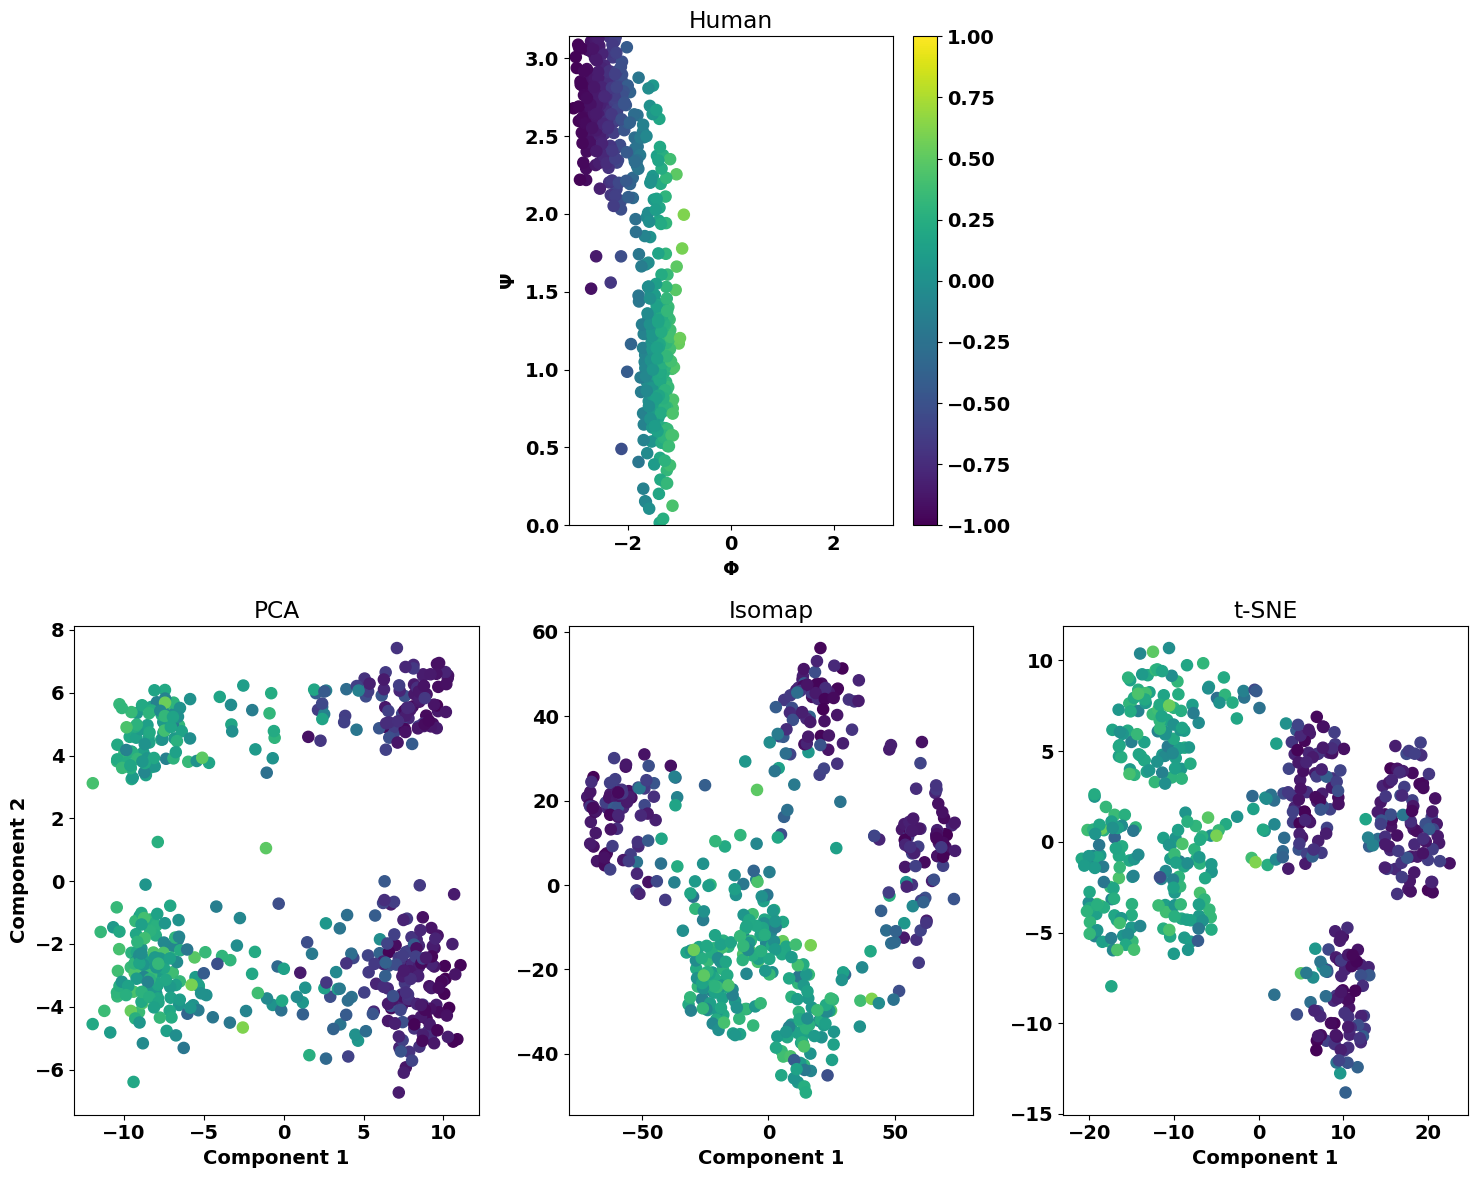

In [16]:
# Perform Principal Component Analysis (PCA) to reduce the dimensionality to 2 components
# This will help visualize the data in a lower-dimensional space while retaining most of the variance
pca = PCA(n_components=2)
pca.fit(tdflat_norm)

# Apply the PCA transformation to the normalized data
# This projects the data onto the first two principal components
tdflat_trans = pca.transform(tdflat_norm)

# Set global plot specifications (fonts, axes labels, marker sizes)
plt.rcParams.update({'font.size': 14,
                     'font.weight' : 'bold',
                     'axes.labelweight': 'bold',
                     'lines.markersize' : 8})

# Create a 2x3 grid of subplots for comparing different dimensionality reduction techniques
fig, axs = plt.subplots(2,3,figsize=(15,12))

# Turn off the axes for the first and third positions in the first row (empty spaces)
axs[0, 0].axis('off')
axs[0, 2].axis('off')

# Plot the human-defined dihedral angles (Phi, Psi) from the trajectory as the first comparison
# Color the scatter plot points based on the values of the first dihedral angle
sc0 = axs[0,1].scatter(-np.arccos(tdihedral[:,0]), np.arccos(tdihedral[:,1]), c=tdihedral[:,0], vmin=-1, vmax=1)
axs[0,1].set_xlabel('$\Phi$')  # Label for the x-axis
axs[0,1].set_ylabel('$\Psi$')  # Label for the y-axis
axs[0,1].set_title('Human')    # Title for the plot
axs[0,1].set_xlim((-np.pi, np.pi))    # Set the limits for the x-axis
axs[0,1].set_ylim((0,  np.pi))    # Set the limits for the y-axis
plt.colorbar(sc0)             # Add a color bar to indicate the range of the first dihedral angle

# Plot the results of PCA (Principal Component Analysis)
# Color the scatter plot points based on the values of the first dihedral angle (similar to the human plot)
sc1 = axs[1,0].scatter(tdflat_trans[:,0], tdflat_trans[:,1], c=tdihedral[:,0], vmin=-1, vmax=1)
axs[1,0].set_xlabel('Component 1')  # Label for the x-axis (first PCA component)
axs[1,0].set_ylabel('Component 2')  # Label for the y-axis (second PCA component)
axs[1,0].set_title('PCA')           # Title for the plot

# Apply Isomap (a nonlinear dimensionality reduction technique) to the data
Isomap_embedding = Isomap(n_components=2)
tdflat_trans_isomap = Isomap_embedding.fit_transform(tdflat_norm)

# Plot the results of Isomap
# Again, color the points based on the first dihedral angle
sc2 = axs[1,1].scatter(tdflat_trans_isomap[:,0], tdflat_trans_isomap[:,1], c=tdihedral[:,0], vmin=-1, vmax=1)
axs[1,1].set_xlabel('Component 1')  # Label for the x-axis (first Isomap component)
axs[1,1].set_title('Isomap')        # Title for the plot

# Apply t-SNE (another nonlinear dimensionality reduction technique) to the data
TSNE_embedding = TSNE(n_components=2, perplexity=50)
tdflat_trans_tsne = TSNE_embedding.fit_transform(tdflat_norm)

# Plot the results of t-SNE
# Color the points based on the first dihedral angle as before
sc3 = axs[1,2].scatter(tdflat_trans_tsne[:,0], tdflat_trans_tsne[:,1], c=tdihedral[:,0], vmin=-1, vmax=1)
axs[1,2].set_xlabel('Component 1')  # Label for the x-axis (first t-SNE component)
axs[1,2].set_title('t-SNE')         # Title for the plot

# Display the plots
plt.tight_layout()
plt.show()